### Importing Libraries and Required Models

In [1]:
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

import torch
import torch.nn as nn

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
USE_model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [3]:
torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

No GPU available, using CPU.


In [4]:
def embed(input):
    return USE_model(input)

### Importing Dataset

In [5]:
DATA_DIR = join('..', 'data', 'glue')

#### Train Dataset

In [6]:
train_full_df = pd.read_csv(join(DATA_DIR, 'train.tsv'), sep='\t')
train_full_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,133273,213221,213222,How is the life of a math student? Could you d...,Which level of prepration is enough for the ex...,0
1,402555,536040,536041,How do I control my horny emotions?,How do you control your horniness?,1
2,360472,364011,490273,What causes stool color to change to yellow?,What can cause stool to come out as little balls?,0
3,150662,155721,7256,What can one do after MBBS?,What do i do after my MBBS ?,1
4,183004,279958,279959,Where can I find a power outlet for my laptop ...,"Would a second airport in Sydney, Australia be...",0


In [7]:
def remove_nulls(df):
    print(f"Initial dataframe has {len(df)} rows.")
    null_rows = df[df.isnull().values.any(1)]
    print(f"Dataframe has {len(null_rows)} null rows.")
    df = df.dropna(how='any')
    print(f"Dataframe has {len(df)} rows after removing null values.")
    return df

In [8]:
train_full_df = remove_nulls(train_full_df)

Initial dataframe has 363846 rows.
Dataframe has 0 null rows.
Dataframe has 363846 rows after removing null values.


In [9]:
train_full_df.shape

(363846, 6)

#### Test Dataset

In [10]:
test_df = pd.read_csv(join(DATA_DIR, 'dev.tsv'), sep='\t')
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,201359,303345,303346,Why are African-Americans so beautiful?,Why are hispanics so beautiful?,0
1,263843,69383,380476,I want to pursue PhD in Computer Science about...,I handle social media for a non-profit. Should...,0
2,172974,266948,175089,Is there a reason why we should travel alone?,What are some reasons to travel alone?,1
3,15329,29298,29299,Why are people so obsessed with having a girlf...,How can a single male have a child?,0
4,209794,314169,314170,What are some good baby girl names starting wi...,What are some good baby girl names starting wi...,0


In [11]:
test_df.shape

(40430, 6)

#### Train and Dev Dataset

In [12]:
train_df, dev_df = train_test_split(train_full_df, test_size=0.1, random_state=42)

In [13]:
len(train_df), len(dev_df)

(327461, 36385)

In [14]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
80519,51432,91228,91229,Which topic is the most followed in Quora?,What topic on Quora has the most followers?,1
349125,52249,92541,92542,What does it feel like to have sex with a rela...,Is it possible to eat more than you weigh?,0
126605,135176,215925,215926,Can I get back my best friend?,How do I get back to my best friend as my lover?,0
6008,184003,281230,281231,Are there solar systems that act like a double...,As a Navy SEAL do you feel as if people are af...,0
292788,5971,11714,11715,Why are there only few magnets?,Why is there only few magnets?,1


In [15]:
dev_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
215130,328831,455423,455424,Why do some people think that having a baby is...,Why is having a baby a blessing?,1
234600,41794,75402,75403,How vulnerable are paratroopers on their desce...,Are conventional paratroopers obsolete?,0
118406,184181,56834,281459,Examples of sole proprietorship? The,How are sole proprietorships started?,0
284746,61939,50127,69389,Why don't I get answers for some of my questio...,Why do some questions get more answers here in...,1
300683,352765,481723,13812,Do Kashmiris wants to join Pakistan?,Do the people of Kashmir want to join Pakistan...,0


### Splitting Into X and y

In [16]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:, -1]

In [17]:
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

In [18]:
X_dev = dev_df.iloc[:,:-1]
y_dev = dev_df.iloc[:,-1]

### Demo

In [19]:
# demo on first 5 questions
q1_concat_q2 = pd.concat([train_df['question1'][:5], train_df['question2'][:5]])

question_embeddings = embed(q1_concat_q2)

In [21]:
question_embeddings = np.array(question_embeddings).tolist()

for i in range(5):
    q1_embedding = np.array(question_embeddings[i]).reshape(1, -1)
    q2_embedding = np.array(question_embeddings[i+5]).reshape(1, -1)

    q1 = train_df['question1'][i]
    q2 = train_df['question2'][i]

    print(f"Question 1: {q1}")
    print(f"Question 2: {q2}")

    cosine_sim = cosine_similarity(q1_embedding, q2_embedding)

    sim_score = cosine_sim[0][0]

    print(f"Similarity score: {sim_score:.4f}\n")

    # message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))
    # print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Question 1: How is the life of a math student? Could you describe your own experiences?
Question 2: Which level of prepration is enough for the exam jlpt5?
Similarity score: 0.8346

Question 1: How do I control my horny emotions?
Question 2: How do you control your horniness?
Similarity score: 0.2979

Question 1: What causes stool color to change to yellow?
Question 2: What can cause stool to come out as little balls?
Similarity score: 0.7228

Question 1: What can one do after MBBS?
Question 2: What do i do after my MBBS ?
Similarity score: 0.0256

Question 1: Where can I find a power outlet for my laptop at Melbourne Airport?
Question 2: Would a second airport in Sydney, Australia be needed if a high-speed rail link was created between Melbourne and Sydney?
Similarity score: 0.9916



### Model Definition

In [22]:
class EmbeddingDifferenceModel(nn.Module):
    
    def __init__(self, input_dim, num_layers, hidden_size=256, use_batchnorm=False):
        super(EmbeddingDifferenceModel, self).__init__()
        
        layers = []
        
        # input layer
        layers.append(nn.Linear(input_dim, hidden_size))
        
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_size))
        
        # hidden layers
        for _ in range(num_layers - 2):
            layers.extend([nn.ReLU(), nn.Linear(hidden_size, hidden_size)])
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
        
        # output layer
        layers.append(nn.Linear(hidden_size, 1))
        
        self.fc = nn.Sequential(*layers)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

### Dataset Preparation

In [24]:
def get_question_embeddings(df):
    df['q1_embeddings'] = df['question1'].apply(lambda x: embed([x]))
    df['q2_embeddings'] = df['question2'].apply(lambda x: embed([x]))
    
    df['q1_embeddings'] = df['q1_embeddings'].apply(lambda x: np.array(x).reshape(-1))
    df['q2_embeddings'] = df['q2_embeddings'].apply(lambda x: np.array(x).reshape(-1))
    
    return df[['q1_embeddings', 'q2_embeddings']] 

In [25]:
X_train = X_train[['question1', 'question2']]
X_train = get_question_embeddings(X_train)
X_train.head()

,q1_embeddings,q2_embeddings
80519,"[-0.07053549, 0.019891663, 0.058807094, -0.031...","[-0.049306873, 0.043122586, 0.031648055, -0.05..."
349125,"[-0.018824844, 0.004940543, -0.011443868, 0.00...","[-0.04775595, -0.0010672337, 0.04243763, 0.053..."
126605,"[-0.040229164, -0.05839186, -0.020360488, 0.00...","[-0.011274554, 0.0008139867, -0.0019748777, -0..."
6008,"[-0.051296253, -0.031798534, -0.026910208, 0.0...","[0.024865713, 0.017299637, -0.0067391163, -0.0..."
292788,"[-0.05238449, -0.028794004, 0.065796725, 0.001...","[-0.05432893, -0.026234463, 0.06770816, -0.001..."


In [26]:
X_test = X_test[['question1', 'question2']]
X_test = get_question_embeddings(X_test)
X_test.head()

,q1_embeddings,q2_embeddings
0,"[0.008276562, -0.029414328, 0.025880737, -0.00...","[0.019892484, -0.020316174, -0.02125712, -0.00..."
1,"[0.07904035, -0.060866363, -0.02071482, 0.0086...","[0.0117558865, -0.042856693, -0.0092335995, -0..."
2,"[0.041346375, -0.044022333, 0.050806224, 0.005...","[0.03366801, -0.07050657, 0.048292905, -0.0267..."
3,"[0.06213628, -0.056327634, -0.026500866, -0.02...","[-0.022136766, -0.04619302, -0.003909536, 0.05..."
4,"[-0.08302937, -0.06837943, -0.02438911, 0.0843...","[-0.08153154, -0.06526433, -0.029430525, 0.083..."


In [27]:
X_dev = X_dev[['question1', 'question2']]
X_dev = get_question_embeddings(X_dev)
X_dev.head()

,q1_embeddings,q2_embeddings
215130,"[0.023980305, -0.07504892, 0.0064894054, -0.04...","[-0.044340335, -0.06813163, 0.035747238, 0.010..."
234600,"[-0.00073044695, 0.044113394, -0.030121082, 0....","[-0.06418873, -0.033711176, -0.028587522, -0.0..."
118406,"[-0.042499803, 0.007981877, -0.080264464, 0.03...","[-0.06065388, -0.025537169, -0.003298814, 0.05..."
284746,"[0.02171729, 0.058587454, 0.058274187, -0.0559...","[-0.010653373, 0.05201364, 0.06448192, -0.0426..."
300683,"[0.059680253, -0.07468135, 0.0011123063, 0.004...","[0.022851152, -0.06449918, 0.008423221, -0.023..."


In [28]:
class DuplicateQuestionDataset(Dataset):

    def __init__(self, question_embeddings, labels):
        self.question_embeddings = question_embeddings
        self.labels = labels

    def __len__(self):
        return len(self.question_embeddings)

    def __getitem__(self, idx):
        q1_embeddings, q2_embeddings = self.question_embeddings.iloc[idx]

        # calculate L1 dist
        result = torch.tensor(np.abs(q1_embeddings - q2_embeddings)).to(device)

        label = torch.tensor(self.labels.iloc[idx]).to(device)
        return result, label

In [29]:
# batch size
batch_size = 128

train_dataset = DuplicateQuestionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DuplicateQuestionDataset(X_dev, y_dev)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DuplicateQuestionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Model Initialisation & Hyperparameter Setting

In [30]:
# hyperparameters
num_layers = 4
hidden_size = 256
learning_rate = 0.001

# constant
input_dim = 512

# initialise model
model = EmbeddingDifferenceModel(input_dim, num_layers=num_layers, hidden_size=hidden_size, use_batchnorm=True).to(device)

# training mode
model.train()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
total_params

264705

### Model Training

In [31]:
num_epochs = 10
lossi = []

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for embedding_diffs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(embedding_diffs)
        loss = criterion(outputs.reshape(-1), labels.float())
        
        # metrics
        lossi.append(loss.item())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.2f}")

100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:13<00:00, 34.89it/s]


Epoch 1: Loss = 0.44


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:11<00:00, 35.73it/s]


Epoch 2: Loss = 0.41


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:11<00:00, 35.84it/s]


Epoch 3: Loss = 0.38


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:14<00:00, 34.43it/s]


Epoch 4: Loss = 0.35


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:10<00:00, 36.41it/s]


Epoch 5: Loss = 0.32


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:13<00:00, 34.62it/s]


Epoch 6: Loss = 0.30


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:10<00:00, 36.25it/s]


Epoch 7: Loss = 0.27


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:11<00:00, 35.55it/s]


Epoch 8: Loss = 0.25


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:10<00:00, 36.49it/s]


Epoch 9: Loss = 0.24


100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:10<00:00, 36.45it/s]

Epoch 10: Loss = 0.22


Text(0.5, 1.0, 'Training Loss')

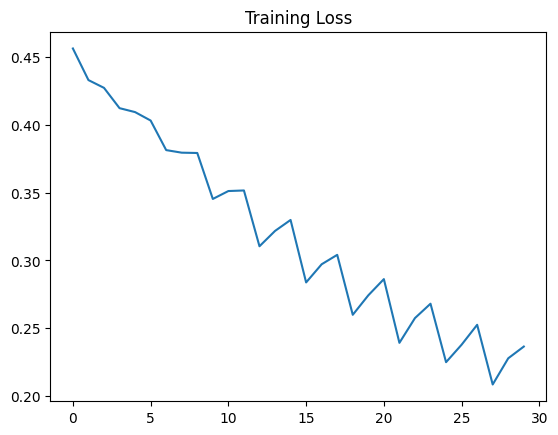

In [33]:
average_lossi = torch.tensor(lossi).view(-1, 853).mean(1)
plt.plot(average_lossi)
plt.title('Training Loss')

### Save Model

In [35]:
model_path = 'embd_diff_model.pth'

In [36]:
torch.save(model.state_dict(), model_path)

### Load Model (Skip here after training is done)

In [57]:
model = EmbeddingDifferenceModel()
model.load_state_dict(torch.load(model_path))
model.eval()

### Model Evaluation

#### Training Accuracy

In [37]:
model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_train = []
    predicted_scores_train = []
    for embd_diffs, labels in tqdm(train_loader):
        outputs = model(embd_diffs)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_train.extend(labels.cpu().numpy())
        predicted_scores_train.extend(outputs.cpu().numpy())

true_labels_train = np.array(true_labels_train)
predicted_scores_train = np.array(predicted_scores_train)

accuracy = accuracy_score(true_labels_train, (predicted_scores_train > threshold)) * 100
print(f"Train Accuracy: {accuracy:.2f}%")

100%|████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:49<00:00, 51.41it/s]


Train Accuracy: 92.94%


#### Validation Accuracy

In [38]:
model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_val = []
    predicted_scores_val = []
    for embd_diffs, labels in tqdm(val_loader):
        outputs = model(embd_diffs)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_val.extend(labels.cpu().numpy())
        predicted_scores_val.extend(outputs.cpu().numpy())

true_labels_val = np.array(true_labels_val)
predicted_scores_val = np.array(predicted_scores_val)

accuracy = accuracy_score(true_labels_val, (predicted_scores_val > threshold)) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

100%|██████████████████████████████████████████████████████████████████████████████████| 285/285 [00:05<00:00, 47.90it/s]

Validation Accuracy: 79.85%


#### Test Accuracy

In [39]:
model.eval()
threshold = 0.5

with torch.no_grad():
    true_labels_test = []
    predicted_scores_test = []
    for embd_diffs, labels in tqdm(test_loader):
        outputs = model(embd_diffs)
        predicted = (outputs > threshold).float().view(-1)

        true_labels_test.extend(labels.cpu().numpy())
        predicted_scores_test.extend(outputs.cpu().numpy())

true_labels_test = np.array(true_labels_test)
predicted_scores_test = np.array(predicted_scores_test)

accuracy = accuracy_score(true_labels_test, (predicted_scores_test > threshold)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

100%|██████████████████████████████████████████████████████████████████████████████████| 316/316 [00:06<00:00, 50.77it/s]

Test Accuracy: 79.51%


#### Other Training Classification Metrics

In [40]:
def print_classification_metrics(dataset='test'):
    labels = {
        'train': (true_labels_train, predicted_scores_train),
        'val': (true_labels_val, predicted_scores_val),
        'test': (true_labels_test, predicted_scores_test)
    }
    true, predicted = labels[dataset]

    print(classification_report(true, (predicted > threshold)))

    fpr, tpr, _ = roc_curve(true, predicted)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset.capitalize()} Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.96      0.93      0.94    206401
           1       0.88      0.93      0.91    121060

    accuracy                           0.93    327461
   macro avg       0.92      0.93      0.93    327461
weighted avg       0.93      0.93      0.93    327461



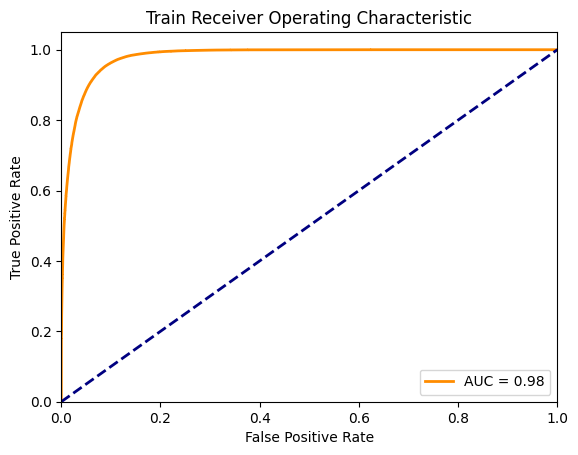

AUC-ROC: 0.98


In [41]:
print_classification_metrics(dataset='train')

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     23067
           1       0.71      0.75      0.73     13318

    accuracy                           0.80     36385
   macro avg       0.78      0.79      0.79     36385
weighted avg       0.80      0.80      0.80     36385



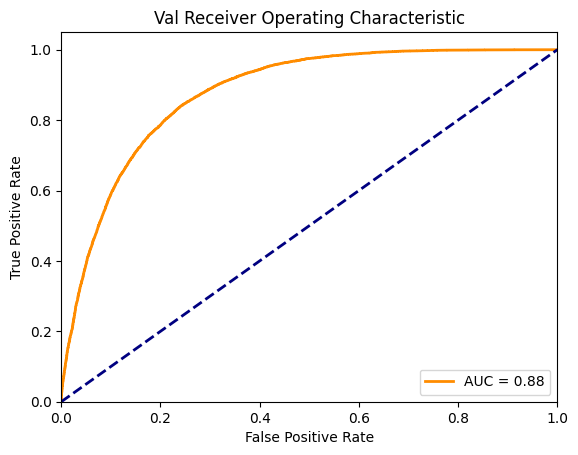

AUC-ROC: 0.88


In [42]:
print_classification_metrics(dataset='val')

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     25545
           1       0.71      0.75      0.73     14885

    accuracy                           0.80     40430
   macro avg       0.78      0.79      0.78     40430
weighted avg       0.80      0.80      0.80     40430



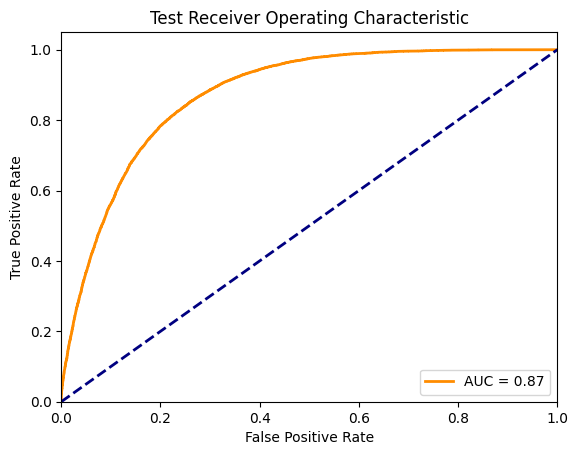

AUC-ROC: 0.87


In [43]:
print_classification_metrics(dataset='test')